**OBJECTIVE:** Run modSAR algorithm on QSAR datasets 

In [1]:
import math
import numpy as np
import pandas as pd

# Import relevant modSAR classes 
from modSAR.network_algorithms import ModSAR
from modSAR.cdk_utils import CDKUtils
from modSAR.datasource import GenericFileDataSource
from modSAR.preprocessing import *
from modSAR.dataset import QSARDataset, QSARDatasetIO

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Geometry
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole 

#from gevent import monkey
#monkey.patch_all()

# 2.5uM in Log units
CUTOFF_ACTIVITY = - np.log10(2.5e-06)

%matplotlib inline

# Load Data

In [2]:
# Read annotated training set compiled by wvanhoorn 
#  https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1#issuecomment-523037719

X = pd.read_excel('/mnt/data/Master Chemical List - annotated.xlsx')
X = X[X["OSM_ID"] != 'OSM-S-424'].copy()
X['pIC50'] = -np.log10(X['Value']* 1e-06)
X.shape

(439, 21)

In [3]:
# Save this preprocessed dataset
X.to_excel('/mnt/data/malaria_osm4_train.xlsx')

In [4]:
# Read the bioactivities in a more standard way with modSAR package

malaria_osm4 = GenericFileDataSource(target_id='malaria_osm4', 
                                     filepath='/mnt/data/malaria_osm4_train.xlsx', 
                                     smiles_column='Canonical_Smiles', 
                                     compound_id_column='OSM_ID', 
                                     activity_column='pIC50',
                                     apply_filter=False)

In [5]:
malaria_osm4.bioactivities_df.query("OSM_ID == 'OSM-S-424'")['Canonical_Smiles'].values

array([], dtype=object)

In [6]:
malaria_osm4.bioactivities_df.head(3)

,Unnamed: 0,OSM_ID,Series,Assay,Value,Qualifier,PfaI EC50 (Inh),Pfal IC50 (GSK),Pfal IC50 (Syngene),Pfal IC50 (Dundee),Pfal IC50 (Avery),Pfal (K1) IC50 (Avery),Pfal IC50 (Ralph),Pfal IC50 (Guy),Pfal (K1) IC50 (Guy),Pfal IC50 (Batra),Pfal (K1) IC50 (Batra),Pfal (3D7) IC50 (Broad),Pfal (Dd2) IC50 (Broad),Canonical_Smiles,InChIKey,pIC50
0,0,OSM-A-1,1,Pfal IC50 (Guy),3.050,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.050,4.379,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,ODRSSOQWOHNABY-MOSHPQCFSA-N,5.515700
1,1,OSM-A-1,1,Pfal (K1) IC50 (Guy),4.379,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.050,4.379,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,ODRSSOQWOHNABY-MOSHPQCFSA-N,5.358625
2,2,OSM-A-2,1,Pfal IC50 (Guy),0.574,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.574,1.829,NaN,NaN,NaN,NaN,Cc1cc(\C=C\2/S\C(=N/c3ccccc3)\NC2=O)c(C)n1c4cc...,LXPLFPVISCVJSC-BKUYFWCQSA-N,6.241088


In [7]:
print("Number of compounds: %d | Number of unique compounds: %d" %
      (malaria_osm4.bioactivities_df.shape[0], malaria_osm4.bioactivities_df['OSM_ID'].nunique()))

Number of compounds: 439 | Number of unique compounds: 347


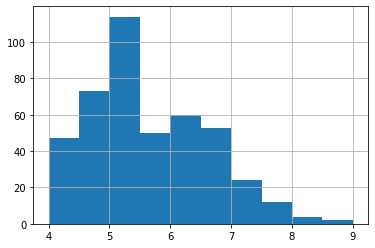

In [8]:
malaria_osm4.bioactivities_df['pIC50'].hist()

## Build QSAR Dataset

In [12]:
# build_qsar_dataset method performs a couple of preprocessing steps:
#  1. Treats duplicated values: A compound is discarded if it has many duplicated compounds and 
#                                 sd(pIC50) > 1 in its group of measurements
#  2. Calculates Molecular Descriptors: Using CDK library (Java)
#  3. Returns a QSARDataset: a python object that encapsulates a full dataset
osm4_dataset = malaria_osm4.build_qsar_dataset(type="ecfp4", calculate_similarity=False)

## Apply cutoff

https://github.com/OpenSourceMalaria/Series4_PredictiveModel/issues/1#issuecomment-524913974

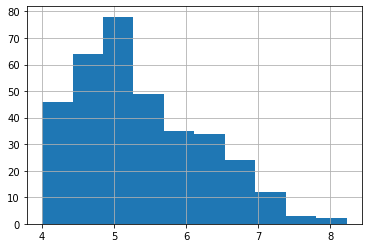

In [13]:
##osm4_dataset.y[osm4_dataset.y < CUTOFF_ACTIVITY] = 0
osm4_dataset.y.hist()

## Similarity on Molecular Descriptors Space

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(osm4_dataset.X.corr(), 'single')

labelList = osm4_dataset.X.index

plt.figure(figsize=(18, 9))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=11)
plt.show()

ValueError: The condensed distance matrix must contain only finite values.

In [14]:
QSARDatasetIO.write(osm4_dataset, filepath='/mnt/data/OSM-S4/osm4_qsardataset.xls')

In [ ]:
QSARDatasetIO.load(dataset_name='OSM4',
                   activity_sheetname='activity',
                   smiles_column='Canonical_Smiles',
                   id_column='OSM_ID',
                   filepath='/mnt/data/OSM-S4/osm4_qsardataset.xls',
                   calculate_similarity=False)

## Calculate Pairwise Similarity

We need to compute the Tanimoto similarity between all compounds before running the algorithm. 

This can be done with the function `calculate_pairwise_tanimoto` from `CDKUtils` class:

In [ ]:
osm4_dataset

In [15]:
cdk_utils = CDKUtils()
# Pass a DataFrame and inform the column that contain SMILES code
similarity_matrix = cdk_utils.calculate_pairwise_tanimoto(osm4_dataset.metadata['Canonical_Smiles'])

Starting CDKBridge


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


Similarity is encoded as a numpy matrix

In [20]:
similarity_matrix.to_csv('/mnt/data/OSM-S4/similarity_values.csv')